线性拟合结果 (Ua = intercept + slope * freq)
  slope = 4.058774e-15 ± 8.283321e-17  V/Hz
  intercept = -1.448170e+00 ± 5.578894e-02  V
  Pearson r = 0.999376, R^2 = 0.998752

由拟合参数计算得到：
  实验普朗克常数 h = 6.502872e-34 ± 1.327134e-35  J·s
  实验功函数 W = 2.320225e-19 ± 8.938374e-21  J
  实验红限频率 v0 = 3.568000e+14 ± 6.684384e+12  Hz
  相对不确定度 (σ_h / h_ref) = 2.0029 %



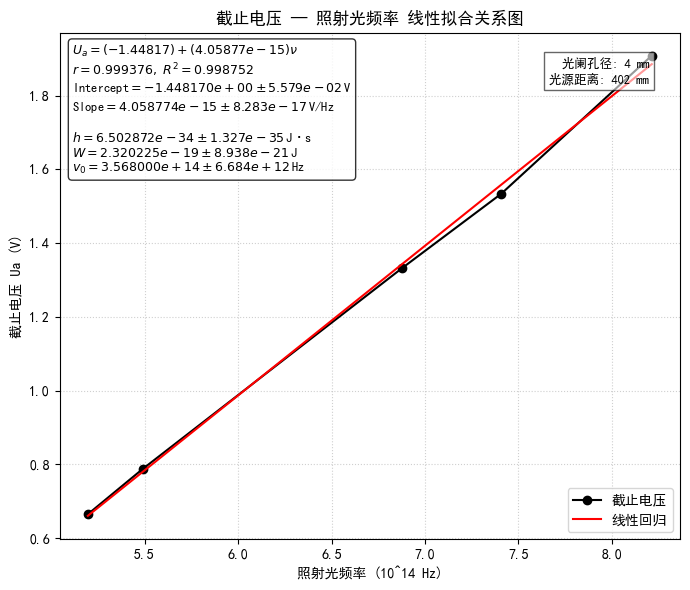

In [15]:
# -*- coding: utf-8 -*-
"""
光电效应截止电压 vs 频率 线性拟合并计算 h, W, v0 及不确定度
将 freq_Hz 和 Ua_V 用实际数据替换（freq 单位：Hz，Ua 单位：V）
"""

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'FangSong']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题

# ----- 用户填入数据（示例为空） -----
# 频率（Hz）
freq_Hz = np.array([
    8.214*1e14,7.408*1e14,6.879*1e14,5.490*1e14,5.196*1e14
])

# 截止电压（V）
Ua_V = np.array([
    1.909,1.534,1.333,0.788,0.665
])

# 检查
if freq_Hz.size != Ua_V.size or freq_Hz.size == 0:
    raise ValueError("请填写相同长度的 freq_Hz 和 Ua_V 数据（单位：Hz 与 V）")

# ----- 常数 -----
e_charge = 1.602176634e-19  # 元素电荷 (C)
h_ref = 6.62607015e-34      # 参考普朗克常数 (J*s) — CODATA recommended value

# ----- 线性拟合 Ua = intercept + slope * freq -----
# 使用 numpy.polyfit 获取协方差矩阵
p, cov = np.polyfit(freq_Hz, Ua_V, 1, cov=True)  # p[0]=slope, p[1]=intercept
slope = p[0]
intercept = p[1]
slope_err = np.sqrt(cov[0,0])
intercept_err = np.sqrt(cov[1,1])
cov_mb = cov[0,1]  # 协方差（slope, intercept）

# 计算相关系数 R^2 与 Pearson r
r_matrix = np.corrcoef(freq_Hz, Ua_V)
pearson_r = r_matrix[0,1]
r_squared = pearson_r**2

# ----- 从拟合参数求物理量并计算不确定度 -----
# h = slope * e
h_exp = slope * e_charge
sigma_h = slope_err * e_charge

# W = - intercept * e
W_exp = - intercept * e_charge
sigma_W = intercept_err * e_charge

# 红限频率 v0 = W / h = -intercept / slope
v0 = - intercept / slope

# 误差传播（考虑 slope 与 intercept 的协方差）
# var(v0) = (1/slope^2)*var(intercept) + (intercept^2/slope^4)*var(slope) - 2*(intercept/slope^3)*cov(slope,intercept)
var_v0 = (1.0 / slope**2) * (intercept_err**2) + \
         (intercept**2 / slope**4) * (slope_err**2) - \
         2.0 * (intercept / slope**3) * cov_mb
sigma_v0 = np.sqrt(abs(var_v0))  # 取绝对值以防数值误差导致负值

# 相对不确定度（与公认 h 比较）
rel_uncertainty_percent = (sigma_h / h_ref) * 100.0

# ----- 输出结果 -----
print("线性拟合结果 (Ua = intercept + slope * freq)")
print(f"  slope = {slope:.6e} ± {slope_err:.6e}  V/Hz")
print(f"  intercept = {intercept:.6e} ± {intercept_err:.6e}  V")
print(f"  Pearson r = {pearson_r:.6f}, R^2 = {r_squared:.6f}")
print()
print("由拟合参数计算得到：")
print(f"  实验普朗克常数 h = {h_exp:.6e} ± {sigma_h:.6e}  J·s")
print(f"  实验功函数 W = {W_exp:.6e} ± {sigma_W:.6e}  J")
print(f"  实验红限频率 v0 = {v0:.6e} ± {sigma_v0:.6e}  Hz")
print(f"  相对不确定度 (σ_h / h_ref) = {rel_uncertainty_percent:.4f} %")
print()

# ----- 绘图（仿照你给的图片样式：数据点 + 拟合直线 + 拟合框） -----
plt.figure(figsize=(7,6))
# 若你在横轴使用 1e14 单位显示，可修改 x_scale_factor 为 1e14 并相应改变标签
x_scale_factor = 1e14  # 将横坐标以 1e14 Hz 单位显示；若不需要，请设为 1.0
x_display = freq_Hz / x_scale_factor

# 绘制数据点与拟合直线
plt.plot(x_display, Ua_V, marker='o', linestyle='-', color='k', label='截止电压')
# 拟合直线（用于绘图）
xfit = np.linspace(freq_Hz.min(), freq_Hz.max(), 200)
yfit = slope * xfit + intercept
plt.plot(xfit / x_scale_factor, yfit, color='r', linewidth=1.5, label='线性回归')

# 注释框（包含拟合方程与参数）
textstr = '\n'.join([
    fr'$U_a = ({intercept:.6g}) + ({slope:.6g})\nu$',
    fr'$r = {pearson_r:.6f},\ R^2 = {r_squared:.6f}$',
    fr'Intercept$={intercept:.6e}\pm{intercept_err:.3e}\,$V',
    fr'Slope$={slope:.6e}\pm{slope_err:.3e}\,$V/Hz',
    '',
    fr'$h = {h_exp:.6e}\pm{sigma_h:.3e}\,$J·s',
    fr'$W = {W_exp:.6e}\pm{sigma_W:.3e}\,$J',
    fr'$v_0 = {v0:.6e}\pm{sigma_v0:.3e}\,$Hz'
])
plt.gca().text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 美化图像
plt.xlabel(f'照射光频率 (10^{int(np.log10(x_scale_factor))} Hz)')  # 当 x_scale_factor=1e14 时显示 10^14
plt.ylabel('截止电压 Ua (V)')
plt.title('截止电压 — 照射光频率 线性拟合关系图')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.6)

# 可选：标注实验光阑/光源距离信息（自行修改）
plt.text(0.95, 0.95, '光阑孔径: 4 mm\n光源距离: 402 mm',
         transform=plt.gca().transAxes, fontsize=9, horizontalalignment='right',
         verticalalignment='top',  # 新增：让文本从顶部对齐，避免超出图像
         bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

# ----- 保存图像（可选） -----
# plt.savefig('Ua_vs_freq_fit.png', dpi=300)


=== 伏安曲线信息 ===
数据点数: 26
估算饱和电流 I_s ≈ 4.400e-09 A
图像已保存为: iv_curve.png


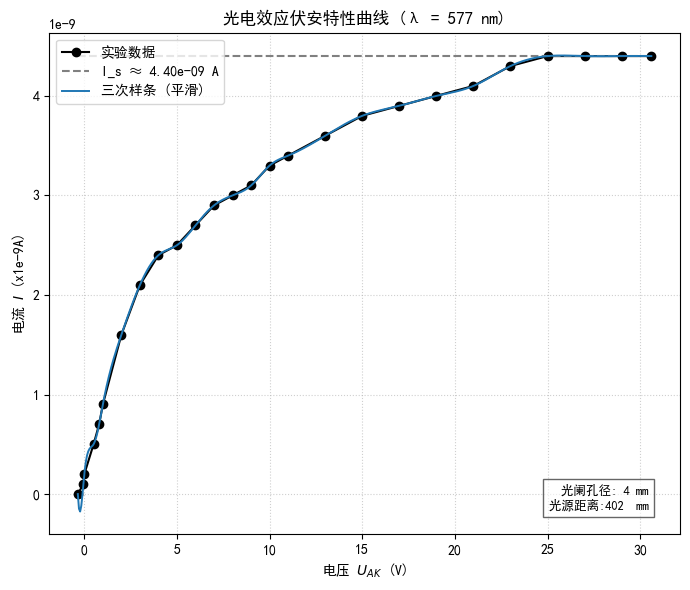

In [16]:
# -*- coding: utf-8 -*-
"""
绘制单一波长下的光电效应伏安特性曲线（不做线性拟合或截止电压求解）
请将 Ua_V 与 I_A 填入真实数据数组后运行。
依赖：numpy, matplotlib
"""
import numpy as np
import matplotlib.pyplot as plt

def plot_iv_curve(Ua_V, I_A, wavelength_nm=None, plotfile=None, verbose=True):
    """
    输入:
      Ua_V: numpy array, 电压 (V)
      I_A:  numpy array, 电流 (A)
      wavelength_nm: int/float or None, 用于图注（可选）
      plotfile: str 或 None, 若给定则保存图片为该文件名
      verbose: 是否打印简单统计信息
    输出:
      result: dict 包含 Ua, I, Is_est, fig, ax
    """
    Ua_V = np.asarray(Ua_V, dtype=float)
    I_A  = np.asarray(I_A, dtype=float)
    if Ua_V.size != I_A.size or Ua_V.size == 0:
        raise ValueError("请填写相同长度的 Ua_V 与 I_A 数组（单位：V，A）。")

    # 将数据按电压从小到大排序（便于绘图）
    order = np.argsort(Ua_V)
    Ua = Ua_V[order]
    I  = I_A[order]

    # 估算饱和电流 Is（选取高电压端若干点平均）
    # 这里取最高 10% 电压区的平均值，若点数太少则取最大的 3 个点平均
    high_mask = Ua >= (Ua.max() - 0.1 * (Ua.max() - Ua.min()))
    if high_mask.sum() < 3:
        high_idx = np.argsort(Ua)[-3:]
        Is_est = np.mean(I[high_idx])
    else:
        Is_est = np.mean(I[high_mask])

    if verbose:
        print("=== 伏安曲线信息 ===")
        print(f"数据点数: {Ua.size}")
        print(f"估算饱和电流 I_s ≈ {Is_est:.3e} A")

    # 绘图
    fig, ax = plt.subplots(figsize=(7,6))
    ax.plot(Ua, I, marker='o', linestyle='-', color='k', label='实验数据')

    # 在图上标出估算的饱和电流
    ax.hlines(Is_est, Ua.min(), Ua.max(), colors='gray', linestyles='--', label=f'I_s ≈ {Is_est:.2e} A')

    # 平滑显示（可选）：样条插值用于绘制平滑曲线
    try:
        from scipy.interpolate import make_interp_spline
        Ua_fit = np.linspace(Ua.min(), Ua.max(), 500)
        spline = make_interp_spline(Ua, I, k=3)
        I_fit_spline = spline(Ua_fit)
        ax.plot(Ua_fit, I_fit_spline, '-', color='tab:blue', linewidth=1.4, label='三次样条 (平滑)')
    except Exception:
        # scipy 未安装或样条失败则跳过平滑曲线
        Ua_fit = Ua
        I_fit_spline = I

    ax.set_xlabel('电压 $U_{AK}$ (V)')
    ax.set_ylabel('电流 $I$ (x1e-9A)')
    title = '光电效应伏安特性曲线'
    if wavelength_nm is not None:
        title += f' (λ = {wavelength_nm} nm)'
    ax.set_title(title)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()
    plt.text(0.95, 0.05, '光阑孔径: 4 mm\n光源距离:402  mm',
         transform=plt.gca().transAxes, fontsize=9, horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.6))
    plt.tight_layout()

    if plotfile:
        plt.savefig(plotfile, dpi=300)
        if verbose:
            print(f"图像已保存为: {plotfile}")

    return {
        'Ua': Ua,
        'I': I,
        'Is_est': Is_est,
        'Ua_fit': Ua_fit,
        'I_fit': I_fit_spline,
        'fig': fig,
        'ax': ax
    }

# -------------------------
# 在这里填入你的数据（示例已填）
Ua_V = np.array([
    -0.35 , -0.05 , 0 , 0.5 , 0.8 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 13 , 15 , 17 , 19 , 21 , 23 , 25 , 27 , 29 , 30.6
])

I_A = np.array([
    0e-10 , 1e-10 , 2e-10 , 5e-10 , 7e-10 , 9e-10 , 16e-10 , 21e-10 , 24e-10 , 25e-10 , 27e-10 , 29e-10 , 30e-10 , 31e-10 , 33e-10 , 34e-10 , 36e-10 , 38e-10 , 39e-10 , 40e-10 , 41e-10 , 43e-10 , 44e-10 , 44e-10 , 44e-10 , 44e-10
])

# 若需要把波长写进图中，填入 wavelength_nm (单位 nm) 或设为 None
wavelength_nm = 577

if __name__ == "__main__":
    res = plot_iv_curve(Ua_V, I_A, wavelength_nm=wavelength_nm, plotfile='iv_curve.png')
    plt.show()


---- 组 1 ----
a, b, c = [2.40340909e-10 1.14318182e-10 2.72727273e-12]
stderr = [6.72281794e-13 5.79879583e-12 9.13625056e-12]
R^2 = 0.999999, adj R^2 = nan, reduced χ² = 9.091e-23

---- 组 2 ----
a, b, c = [1.24602273e-09 8.29545455e-11 6.81818182e-11]
stderr = [1.68070448e-11 1.44969896e-10 2.28406264e-10]
R^2 = 0.999986, adj R^2 = nan, reduced χ² = 5.682e-20



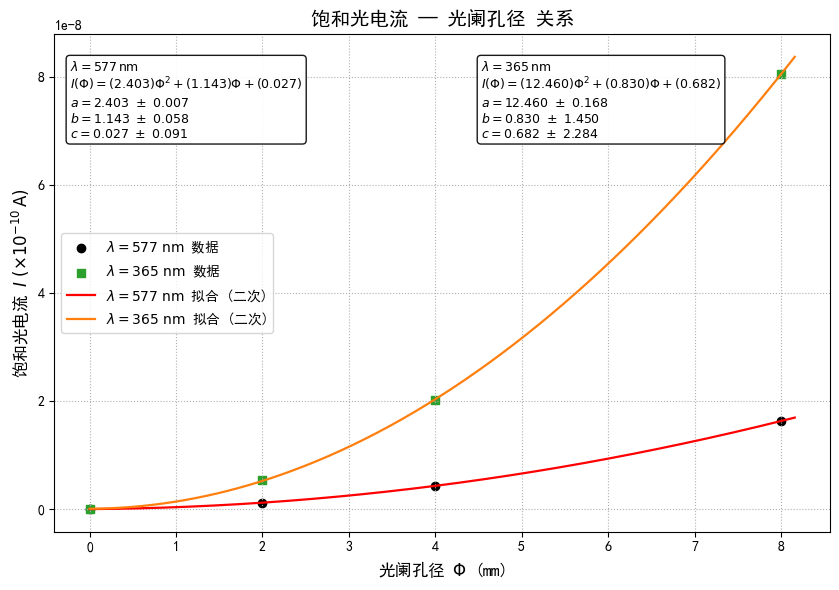

LaTeX 表达式（组1）：
 $I(\Phi)=(2.403)\Phi^2+(1.143)\Phi+(0.027)$
$a=2.403\ \pm\ 0.007$
$b=1.143\ \pm\ 0.058$
$c=0.027\ \pm\ 0.091$

LaTeX 表达式（组2）：
 $I(\Phi)=(12.460)\Phi^2+(0.830)\Phi+(0.682)$
$a=12.460\ \pm\ 0.168$
$b=0.830\ \pm\ 1.450$
$c=0.682\ \pm\ 2.284$


In [31]:
# -*- coding: utf-8 -*-
"""
对两组 (phi, I) 数据分别做二次多项式拟合并绘图（I = a*phi^2 + b*phi + c）
图中展示二次表达式，系数以科学计数法显示并保留 3 位有效数字。
兼容点数过少的情形：若数据点不足以估计协方差则 stderr 显示为 nan。
依赖: numpy, matplotlib
"""
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 填入你的数据（单位：phi -> mm；I -> A）
phi1 = np.array([0.0, 2.0, 4.0, 8.0], dtype=float)
I1  = np.array([0.0, 12.0, 43.0, 163.0], dtype=float) * 1e-10   # 若表中为 ×10^-10 A，保留 *1e-10

phi2 = np.array([0.0, 2.0, 4.0, 8.0], dtype=float)
I2  = np.array([0.0, 54.0, 202.0, 805.0], dtype=float) * 1e-10

# 标签
label1 = r'$\lambda=577\ \mathrm{nm}$'
label2 = r'$\lambda=365\ \mathrm{nm}$'

# -----------------------------
def quad_fit_stats(phi, I):
    phi = np.asarray(phi, dtype=float)
    I = np.asarray(I, dtype=float)
    N = phi.size
    deg = 2
    param_count = deg + 1  # 3

    # 若点数足够，计算协方差，否则只返回系数，stderr 为 nan
    if N >= param_count + 1:  # N >= 4
        coeffs, cov = np.polyfit(phi, I, deg=deg, cov=True)
        stderr = np.sqrt(np.abs(np.diag(cov)))
    else:
        coeffs = np.polyfit(phi, I, deg=deg)
        stderr = np.array([np.nan] * param_count)

    p = np.poly1d(coeffs)
    I_fit = p(phi)
    residuals = I - I_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((I - np.mean(I))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    adj_r2 = 1 - (1 - r2) * (N - 1) / (N - param_count - 1) if (N - param_count - 1) > 0 else np.nan
    dof = max(N - param_count, 1)
    reduced_chi2 = ss_res / dof

    return {
        'coeffs': coeffs,         # [a, b, c]
        'stderr': stderr,         # [σ_a, σ_b, σ_c] or nan
        'I_fit': I_fit,
        'residuals': residuals,
        'ss_res': ss_res,
        'ss_tot': ss_tot,
        'r2': r2,
        'adj_r2': adj_r2,
        'reduced_chi2': reduced_chi2,
        'N': N
    }

# 执行拟合
res1 = quad_fit_stats(phi1, I1)
res2 = quad_fit_stats(phi2, I2)

# 辅助：格式化系数（科学计数法，保留3位有效数字）
def fmt_sci(x):
    return f"{x*(1e+10):.3f}"

# 生成用于图中显示的 LaTeX 表达式（系数用科学计数法保留3位）
def make_latex_expr(coeffs, stderr=None, wavelength_nm=None):
    a, b, c = coeffs
    header = ""
    if wavelength_nm is not None:
        header = rf"$\lambda = {wavelength_nm}\,\mathrm{{nm}}$" + "\n"
    if stderr is None or np.isnan(stderr).all():
        expr = (
            header +
            rf"$I(\Phi)=({fmt_sci(a)})\Phi^2+({fmt_sci(b)})\Phi+({fmt_sci(c)})$"
        )
    else:
        ea, eb, ec = stderr
        expr = (
            header +
            rf"$I(\Phi)=({fmt_sci(a)})\Phi^2+({fmt_sci(b)})\Phi+({fmt_sci(c)})$" + "\n" +
            rf"$a={fmt_sci(a)}\ \pm\ {fmt_sci(ea)}$" + "\n" +
            rf"$b={fmt_sci(b)}\ \pm\ {fmt_sci(eb)}$" + "\n" +
            rf"$c={fmt_sci(c)}\ \pm\ {fmt_sci(ec)}$"
        )
    return expr

# 打印控制台结果
def print_summary(res, label):
    coeffs = res['coeffs']; errs = res['stderr']
    print("----", label, "----")
    print("a, b, c =", coeffs)
    print("stderr =", errs)
    print(f"R^2 = {res['r2']:.6f}, adj R^2 = {res['adj_r2']:.6f}, reduced χ² = {res['reduced_chi2']:.3e}")
    print()

print_summary(res1, '组 1')
print_summary(res2, '组 2')

# 绘图
plt.figure(figsize=(8.5,6))
scale_factor = 1.0  # 若希望以 ×10^-10 A 显示，乘以此因子；否则设为 1.0
plt.scatter(phi1, I1*scale_factor, marker='o', color='k', label=f"{label1} 数据")
plt.scatter(phi2, I2*scale_factor, marker='s', color='tab:green', label=f"{label2} 数据")

phi_plot = np.linspace(min(phi1.min(), phi2.min())*0.98, max(phi1.max(), phi2.max())*1.02, 400)
p1 = np.poly1d(res1['coeffs']); p2 = np.poly1d(res2['coeffs'])
I_plot1 = p1(phi_plot); I_plot2 = p2(phi_plot)

plt.plot(phi_plot, I_plot1*scale_factor, '-', color='r', lw=1.6, label=f"{label1} 拟合 (二次)")
plt.plot(phi_plot, I_plot2*scale_factor, '-', color='tab:orange', lw=1.6, label=f"{label2} 拟合 (二次)")

# 在图上添加带系数的表达式（LaTeX），放在合适位置
expr1 = make_latex_expr(res1['coeffs'], res1['stderr'], wavelength_nm=577)
expr2 = make_latex_expr(res2['coeffs'], res2['stderr'], wavelength_nm=365)
plt.gca().text(0.02, 0.95, expr1, transform=plt.gca().transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
plt.gca().text(0.55, 0.95, expr2, transform=plt.gca().transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.xlabel("光阑孔径 $\\Phi$ (mm)", fontsize=12)
plt.ylabel(r"饱和光电流 $I\ (\times 10^{-10}\,\mathrm{A})$", fontsize=12)
plt.title("饱和光电流 — 光阑孔径 关系", fontsize=14)
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

# 另外：把 LaTeX 表达式以文本形式打印（方便复制进报告）
print("LaTeX 表达式（组1）：\n", make_latex_expr(res1['coeffs'], res1['stderr']))
print("\nLaTeX 表达式（组2）：\n", make_latex_expr(res2['coeffs'], res2['stderr']))


C:\Users\19599\AppData\Local\Temp\ipykernel_46128\1686147587.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(model, L, I, p0=p0, bounds=bounds, maxfev=10000)


=== 组1 (invsq) : I = A/L^2 + B ===
  A = 1.114462e-03 ± 2.93e-05
  B = -2.715314e-09 ± 2.56e-10
  R^2 = 0.999308, adj R^2 = nan, reduced χ² = 1.032e-20

=== 组1 (power) : I = C*L^n + D ===
  C = 4.334941e-02 ± inf
  n = -2.678412e+00 ± inf
  D = -3.515082e-10 ± inf
  R^2 = 1.000000, adj R^2 = nan, reduced χ² = 1.163e-47

=== 组2 (invsq) : I = A/L^2 + B ===
  A = 5.307421e-03 ± 1.67e-04
  B = -1.285620e-08 ± 1.46e-09
  R^2 = 0.999007, adj R^2 = nan, reduced χ² = 3.359e-19

=== 组2 (power) : I = C*L^n + D ===
  C = 4.351279e-01 ± inf
  n = -2.814971e+00 ± inf
  D = -1.271298e-12 ± inf
  R^2 = 1.000000, adj R^2 = nan, reduced χ² = 2.551e-45



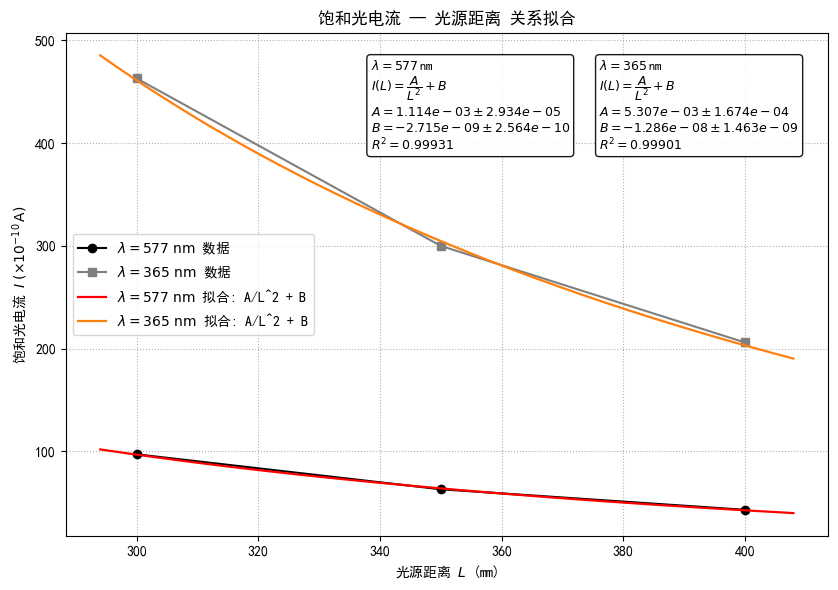

幂律拟合指数检验（n 是否接近 -2）:
组1: n = -2.67841 ± inf
组2: n = -2.81497 ± inf


In [33]:
# -*- coding: utf-8 -*-
"""
拟合并绘制：饱和光电流 I vs 光源距离 L
模型1: I(L) = A / L^2 + B    (用于验证反比平方)
模型2: I(L) = C * L^n + D    (幂律拟合，n 自由，供比较)

使用：把 L1,I1,L2,I2 数组替换为你的数据（L 单位 mm；I 单位 A）。
依赖：numpy, scipy, matplotlib
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --------------------------
# 填入你的数据（示例占位）
# L 单位：mm
# I 单位：A
# 如果表格给出 I 以 "×10^-10 A" 为单位，记得把数值乘以 1e-10
L1 = np.array([300., 350., 400.])    # 示例：波长1 的距离数据
I1 = np.array([97., 63., 43.]) * 1e-10  # 若表格单位为 ×10^-10 A，则乘 1e-10；否则直接给 A 单位

L2 = np.array([300., 350., 400.])    # 波长2 的距离数据
I2 = np.array([463., 300., 206.]) * 1e-10

# 标签（在图中显示）
label1 = r'$\lambda=577\ \mathrm{nm}$'   # 改成你实际的波长标签
label2 = r'$\lambda=365\ \mathrm{nm}$'

# --------------------------
# 定义模型
def invsq_model(L, A, B):
    return A / (L**2) + B

def power_model(L, C, n, D):
    return C * (L**n) + D

# 拟合并计算统计量的辅助函数
def fit_model_and_stats(model, L, I, p0=None, bounds=(-np.inf, np.inf)):
    popt, pcov = curve_fit(model, L, I, p0=p0, bounds=bounds, maxfev=10000)
    perr = np.sqrt(np.abs(np.diag(pcov)))  # 参数标准偏差
    I_fit = model(L, *popt)
    residuals = I - I_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((I - np.mean(I))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    N = L.size
    p = len(popt)
    adj_r2 = 1 - (1 - r2) * (N - 1) / (N - p - 1) if (N - p - 1) > 0 else np.nan
    dof = max(N - p, 1)
    reduced_chi2 = ss_res / dof
    return {
        'popt': popt,
        'perr': perr,
        'I_fit': I_fit,
        'residuals': residuals,
        'ss_res': ss_res,
        'ss_tot': ss_tot,
        'r2': r2,
        'adj_r2': adj_r2,
        'reduced_chi2': reduced_chi2,
        'N': N, 'p': p
    }

# 小工具：格式化科学计数法，保留3位有效数字
def fmt(x):
    return f"{x:.3e}"

# --------------------------
# 执行拟合（组1）
res1_invsq = fit_model_and_stats(invsq_model, L1, I1, p0=[1e5, 0.0])
res1_power = fit_model_and_stats(power_model, L1, I1, p0=[1e-6, -2.0, 0.0])

# 组2
res2_invsq = fit_model_and_stats(invsq_model, L2, I2, p0=[1e6, 0.0])
res2_power = fit_model_and_stats(power_model, L2, I2, p0=[1e-6, -2.0, 0.0])

# --------------------------
# 打印结果
def print_res(name, res, model_name, param_names):
    popt = res['popt']; perr = res['perr']
    print(f"=== {name} : {model_name} ===")
    for n, (pv, pe) in enumerate(zip(popt, perr)):
        print(f"  {param_names[n]} = {pv:.6e} ± {pe:.2e}")
    print(f"  R^2 = {res['r2']:.6f}, adj R^2 = {res['adj_r2']:.6f}, reduced χ² = {res['reduced_chi2']:.3e}")
    print()

print_res("组1 (invsq)", res1_invsq, "I = A/L^2 + B", ["A","B"])
print_res("组1 (power)", res1_power, "I = C*L^n + D", ["C","n","D"])
print_res("组2 (invsq)", res2_invsq, "I = A/L^2 + B", ["A","B"])
print_res("组2 (power)", res2_power, "I = C*L^n + D", ["C","n","D"])

# --------------------------
# 绘图（数据点 + 两种拟合曲线，可按需只保留 invsq）
plt.figure(figsize=(8.5,6))
# 显示原始数据点（可放大单位以便观察；这里保持 I 的实际单位）
plt.plot(L1, I1*1e10, 'o-', color='k', label=f"{label1} 数据")
plt.plot(L2, I2*1e10, 's-', color='tab:gray', label=f"{label2} 数据")

# 细网格用于绘制光滑拟合曲线
L_plot = np.linspace(min(L1.min(), L2.min())*0.98, max(L1.max(), L2.max())*1.02, 300)

# 组1 拟合曲线（inv-square）
A1, B1 = res1_invsq['popt']
I_plot1 = invsq_model(L_plot, A1, B1)
plt.plot(L_plot, I_plot1*1e10, '-', color='r', lw=1.6, label=f"{label1} 拟合: A/L^2 + B")

# 组2 拟合曲线（inv-square）
A2, B2 = res2_invsq['popt']
I_plot2 = invsq_model(L_plot, A2, B2)
plt.plot(L_plot, I_plot2*1e10, '-', color='tab:orange', lw=1.6, label=f"{label2} 拟合: A/L^2 + B")

# 注释框：显示拟合式与参数（科学计数法，3 位有效）
def make_box_text_invsq(res, label, wavelength_nm=None):
    A, B = res['popt']; sA, sB = res['perr']
    header = f"{label}\n" if wavelength_nm is None else f"$\\lambda={wavelength_nm}\\,$nm\n"
    lines = [
        header + r"$I(L)=\dfrac{A}{L^2}+B$",
        f"$A={fmt(A)}\\pm{fmt(sA)}$",
        f"$B={fmt(B)}\\pm{fmt(sB)}$",
        f"$R^2={res['r2']:.5f}$"
    ]
    return "\n".join(lines)

txt1 = make_box_text_invsq(res1_invsq, label1, wavelength_nm=577)
txt2 = make_box_text_invsq(res2_invsq, label2, wavelength_nm=365)
plt.gca().text(0.40, 0.95, txt1, transform=plt.gca().transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
plt.gca().text(0.70, 0.95, txt2, transform=plt.gca().transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.xlabel("光源距离 $L$ (mm)")
plt.ylabel(r"饱和光电流 $I\ (\times 10^{-10}\,\mathrm{A})$")  # 我这里将绘图 y 放大了 1e10
plt.title("饱和光电流 — 光源距离 关系拟合")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# 可选：将幂律拟合的指数 n 打印出来，检验是否接近 -2
print("幂律拟合指数检验（n 是否接近 -2）:")
print(f"组1: n = {res1_power['popt'][1]:.5f} ± {res1_power['perr'][1]:.2e}")
print(f"组2: n = {res2_power['popt'][1]:.5f} ± {res2_power['perr'][1]:.2e}")
